In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import re
import io
import matplotlib.pylab as plt
from fa2 import ForceAtlas2
import json
import ast
from collections import Counter
import pickle
import community

In [71]:
g = nx.read_gpickle("popular_directors_network.gpickle")

In [72]:
g.number_of_nodes()

1273

In [5]:
g.number_of_edges()

217725

In [56]:
degrees = g.degree()
list_degrees_with_names = sorted(degrees, key=lambda x: x[1], reverse=True)

In [57]:
print('Director who has actors in common with most directors',list_degrees_with_names[0][0])
print('Has actors in common with ' + str(list_degrees_with_names[0][1]) + ' different directors')

Director who has actors in common with most directors Steven Spielberg
Has actors in common with 901 different directors


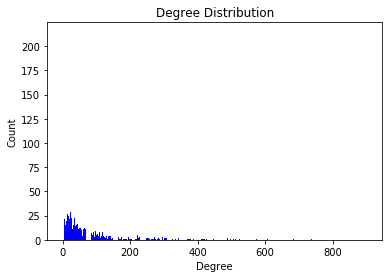

In [58]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

In [59]:
degrees_list =[x[1] for x in g.degree()]
print('average: ', np.average(degrees_list))
print('median: ', np.median(degrees_list))
print('mode: ', sorted(degrees_list, key=degrees_list.count, reverse=True)[0])
print('min: ', np.min(degrees_list))
print('max: ', np.max(degrees_list))

average:  85.53560975609756
median:  40.0
mode:  0
min:  0
max:  901


In [60]:
print('Top 5 directors regarding degree')
for name,_ in (list_degrees_with_names)[0:5]:
    print(name)

Top 5 directors regarding degree
Steven Spielberg
Oliver Stone
Tony Scott
Ridley Scott
Joel Schumacher


In [74]:
gc = max(nx.connected_component_subgraphs(g), key=len)

In [62]:
betweeness_centrality = nx.betweenness_centrality(gc)

In [63]:
list_betweeness_centrality = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding betweeness centrality')
for name,d in (list_betweeness_centrality)[0:5]:
    print(name)

Top 5 directors regarding betweeness centrality
Steven Spielberg
Oliver Stone
Tony Scott
Ridley Scott
Robert Altman


In [64]:
eigenvector_centrality = nx.eigenvector_centrality(gc)
list_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
print('Top 5 directors regarding eigenvector centrality')
for name,d in (list_eigenvector_centrality)[0:5]:
    print(name)

Top 5 directors regarding eigenvector centrality
Steven Spielberg
Oliver Stone
Tony Scott
Ridley Scott
Joel Schumacher


In [75]:
gc.number_of_nodes()

1272

In [77]:
partition = community.best_partition(gc)
print('Modularity:', community.modularity(partition, gc))

Modularity: 0.2283826250097813


In [76]:
len(list(nx.connected_component_subgraphs(g)))

2

In [78]:
partition

{'John Lasseter': 0,
 'Martin Scorsese': 1,
 'Mike Figgis': 2,
 'Amy Heckerling': 1,
 'David Fincher': 2,
 'Ron Howard': 1,
 'Michael Moore': 1,
 'Iain Softley': 2,
 'Kevin Lima': 0,
 'John Pasquin': 0,
 'Louis Malle': 3,
 'Robert Zemeckis': 1,
 'Penelope Spheeris': 1,
 'Michael Apted': 2,
 'Abel Ferrara': 1,
 'Jonathan Demme': 1,
 'Nora Ephron': 0,
 'Peter Jackson': 2,
 'Tom Hanks': 0,
 'Garry Marshall': 0,
 'Irvin Kershner': 4,
 'Rob Reiner': 1,
 'Francis Ford Coppola': 1,
 'Stanley Kubrick': 4,
 'Woody Allen': 1,
 'Richard Attenborough': 4,
 'Oliver Stone': 1,
 'Sidney Lumet': 4,
 'Wes Craven': 0,
 'Sean McNamara': 0,
 'Warren Beatty': 1,
 'Terry Gilliam': 2,
 'Steven Spielberg': 2,
 'Joe Dante': 1,
 'Howard Deutch': 1,
 'Neil Jordan': 2,
 'Michael Ritchie': 1,
 'Richard Benjamin': 1,
 'Donald Petrie': 1,
 'Richard Donner': 1,
 'Richard Lester': 4,
 'Robert Wise': 4,
 'Ivan Reitman': 1,
 'Curtis Hanson': 1,
 'Penny Marshall': 1,
 'Jon Amiel': 2,
 'Brian De Palma': 1,
 'Frank Darabon